In [ ]:
!gdown '1dtSfWoas01RlBcoXvdt7LDGT4MgfBNxq'

### 设置超参数

In [1]:
IMG_SIZE = 320
BATCH_SIZE = 2
EPOCHS = 1000
NUM_KEYPOINTS = 1 * 2  # 1 pairs each having x and y coordinates

### 准备数据集

In [ ]:
!unzip -oq dataset.zip
!rm -rf ./dataset/.git
!rm -rf ./dataset/.DS_Store
!rm -rf ./dataset/train/.DS_Store
!rm -rf ./dataset/validation/.DS_Store
!rm -rf __MACOSX
!rm -rf ./resized
!mkdir ./resized
!mkdir ./resized/train
!mkdir ./resized/validation

### 加载数据集，将数据集转换成如下格式的字典。

```json
{
  "image_path1" => [627.6153846153846, 872.6410256410256, ...],
  "image_path2" => [...]
}
```

In [2]:
import os
import json
import pathlib
from PIL import Image
from matplotlib import pyplot as plt

def unzip_dataset(path, resize_path):
  json_dict = {}
  for p in pathlib.Path(path).glob('*'):
    plate = p.name  
    path = str(p)
    with open(f"{path}/{plate}.json") as file:
#       os.mkdir(f"{resize_path}/{plate}")

      resized_image_path = f"{resize_path}/{plate}/{plate}.jpg"

      image = Image.open(f"{path}/{plate}.jpg")
#       resized_image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
#       resized_image.save(resized_image_path)

      labels = []
      points = json.load(file)['shapes'][0]['points']
      left_right = sorted(points, key=lambda i: i[0])
      left_points, right_points = left_right[:2], left_right[2:]
      left_points = sorted(left_points, key=lambda i: i[1])
      right_points = sorted(right_points, key=lambda i: i[1])
      sorted_points = [left_points[0], left_points[1], right_points[1], right_points[0]]

#       for p in sorted_points:
#         labels.append(p[0] / image.width)
#         labels.append(p[1] / image.height)

      point = sorted_points[2]
      labels.append(point[0] / image.width)
      labels.append(point[1] / image.height)

      json_dict[resized_image_path] = labels
  return json_dict     

train_dict = unzip_dataset('./dataset/train', './resized/train')
validation_dict = unzip_dataset('./dataset/validation', './resized/validation')

### 构建数据集

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt

train_keys = train_dict.keys()
validation_keys = validation_dict.keys()
train_labels = [train_dict[p] for p in train_keys]
validation_labels = [validation_dict[p] for p in validation_keys]

def load_and_preprocess_image(plate, label):
  img = tf.io.read_file(plate)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0

  return img, label

train_dataset = (
  tf.data.Dataset.from_tensor_slices((train_keys, train_labels))
    .shuffle(len(train_keys))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(25)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = (
  tf.data.Dataset.from_tensor_slices((validation_keys, validation_labels))
    .cache()
    .map(load_and_preprocess_image, tf.data.experimental.AUTOTUNE)
    .batch(10)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)    
)

### 定义显示关键点方法

In [4]:
import numpy as np

def visualize_keypoints(images, keypoints):
  fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(16, 12))
  [ax.axis("off") for ax in np.ravel(axes)]

  for ax_all, image, kp in zip(axes, images, keypoints):
    ax_all.imshow(image)
#     for i in range(0, 4):
#       ax_all.scatter([kp[i * 2] * IMG_SIZE], [kp[i * 2 + 1] * IMG_SIZE], c='red', marker="x", s=50, linewidths=5)
    ax_all.scatter([kp[0 * 2] * IMG_SIZE], [kp[0 * 2 + 1] * IMG_SIZE], c='red', marker="x", s=50, linewidths=5)

  plt.tight_layout(pad=2.0)
  plt.show()

### 检查一下数据

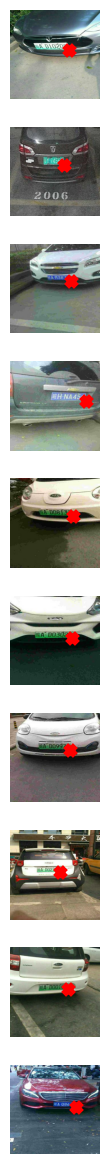

In [5]:
def load_sample(plate):
  img = tf.io.read_file(plate)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0
  return img

for image, points in validation_dataset.take(1):
  sample_image, sample_points = image, points

visualize_keypoints(sample_image, sample_points)

### 构建模型

In [71]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(image_size):
  return tf.keras.models.Sequential([
    layers.Input(shape=(image_size[0], image_size[1], 3)),
    layers.Conv2D(21, kernel_size=(9, 9), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(15, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(15, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(15, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(15, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(12, kernel_size=(3, 3), activation='relu'),
    layers.Dropout(0.1),  
    layers.Conv2D(15, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(12, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(12, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(12, kernel_size=(3, 3), activation='relu'),
    layers.Dropout(0.1),  
    layers.Conv2D(12, kernel_size=(3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=2)  
  ])

### 生成模型

In [72]:
model = build_model((IMG_SIZE, IMG_SIZE))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_220 (Conv2D)         (None, 312, 312, 21)      5124      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 156, 156, 21)     0         
 g2D)                                                            
                                                                 
 conv2d_221 (Conv2D)         (None, 154, 154, 15)      2850      
                                                                 
 conv2d_222 (Conv2D)         (None, 152, 152, 15)      2040      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 76, 76, 15)       0         
 g2D)                                                            
                                                                 
 conv2d_223 (Conv2D)         (None, 74, 74, 15)      

### 预览模型架构

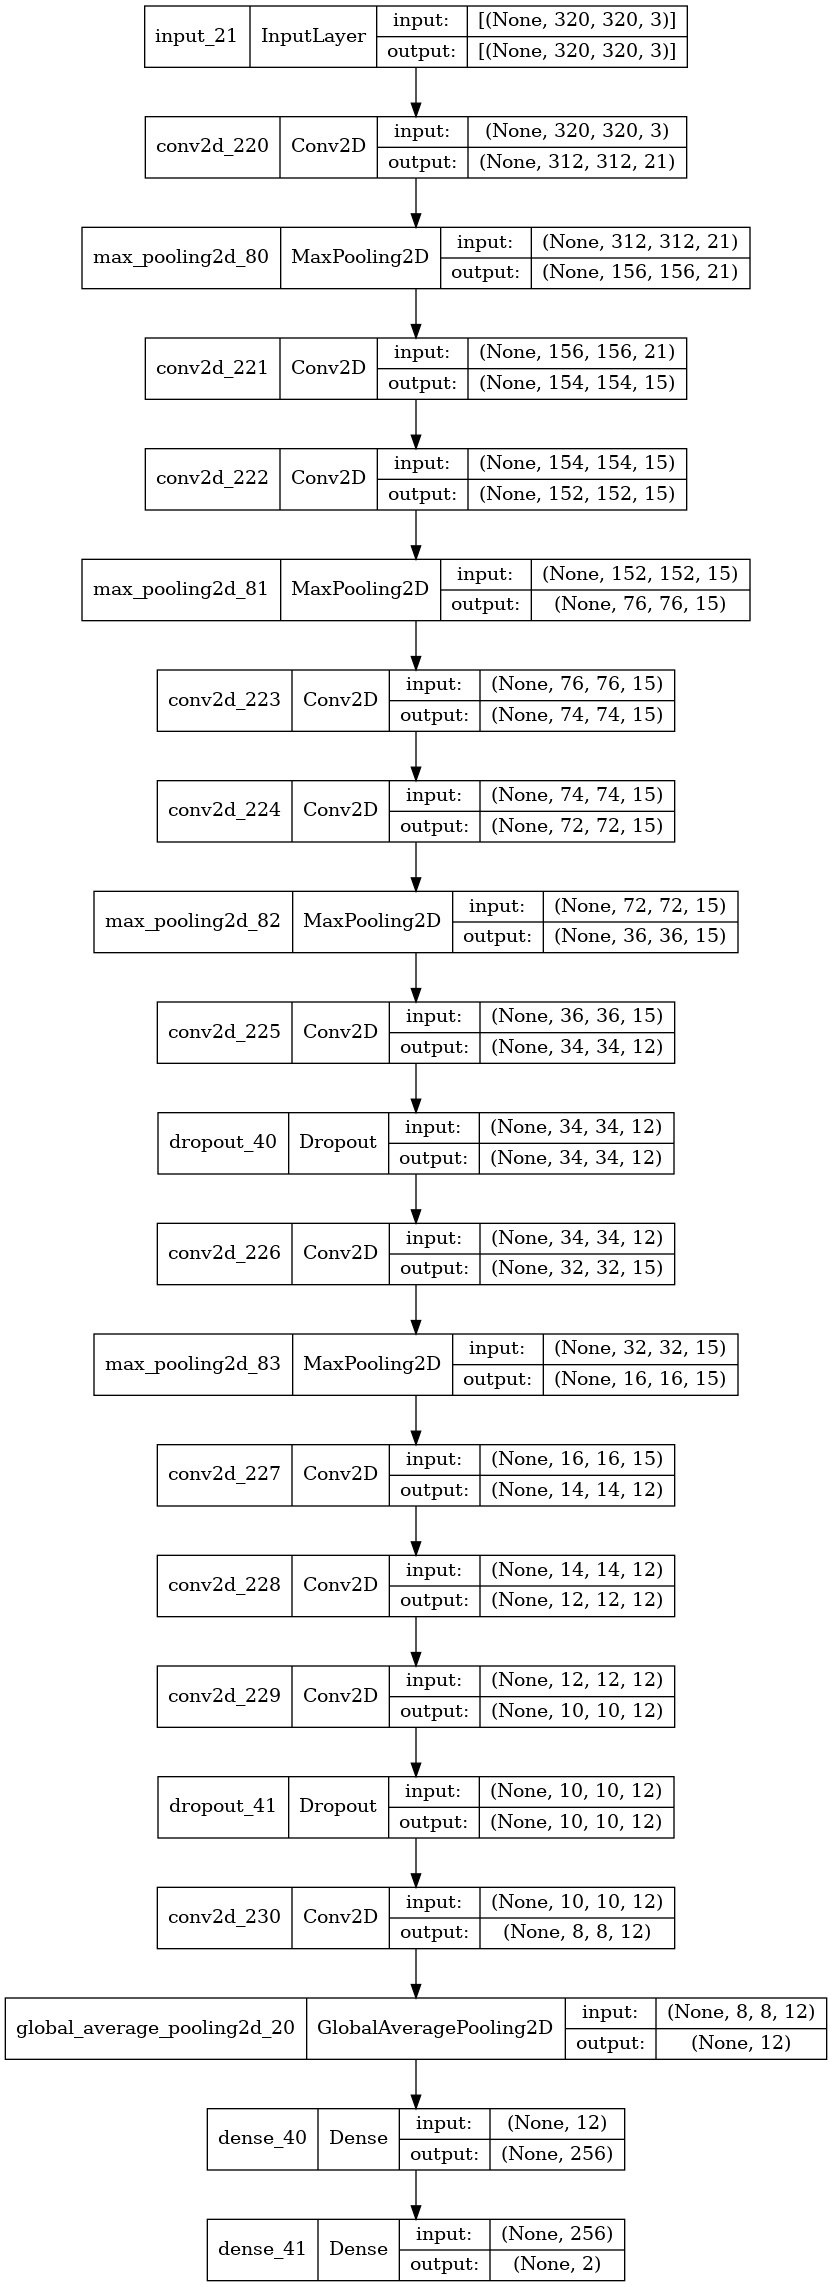

In [73]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [74]:
if os.path.exists('detect.h5'):
  print('load pretrain model')
  model = tf.keras.models.load_model('detect.h5')
  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-8))

load pretrain model


In [75]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=1, steps_per_epoch=209)
model.save('detect.h5')

209/209 [==============================] - 13s 58ms/step - loss: 6.6482e-06 - val_loss: 2.5745e-04


### 检验训练拟合度和验证集情况

训练拟合度


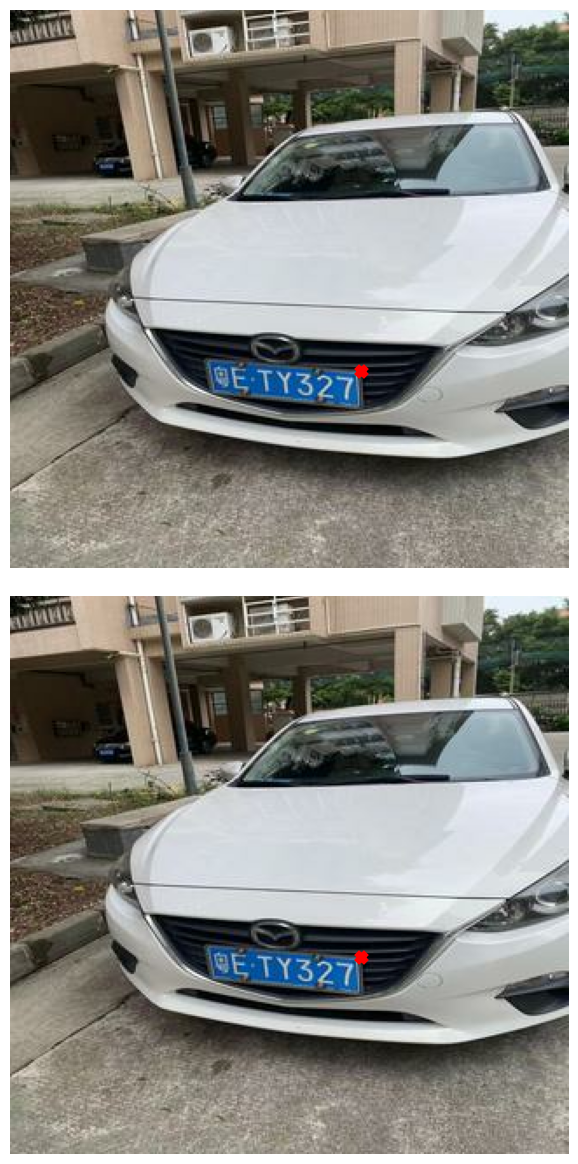

模型预测


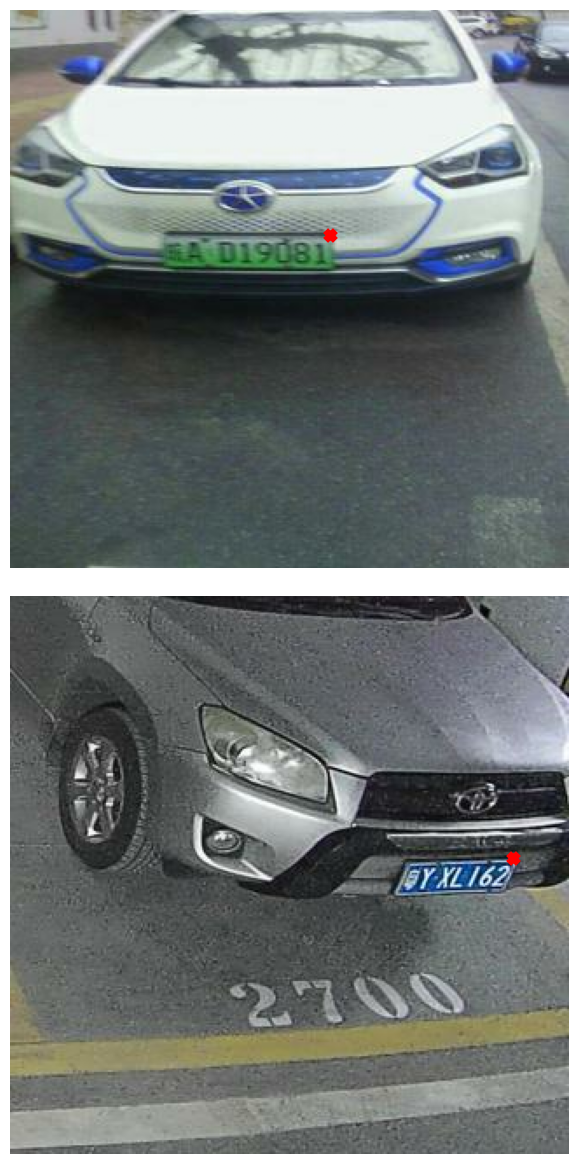

In [76]:
model.save('detect.h5')
print("训练拟合度")
sample_image = np.array([
  load_sample('./resized/train/粤ETY327/粤ETY327.jpg'), 
  load_sample('./resized/train/粤ETY327/粤ETY327.jpg')
])
visualize_keypoints(sample_image, model.predict(sample_image))

print("模型预测")
sample_image = np.array([
  load_sample('./resized/validation/5637/5637.jpg'), 
  load_sample('./resized/validation/粤YXLI62/粤YXLI62.jpg')
])
visualize_keypoints(sample_image, model.predict(sample_image))

### 调整学习率

In [14]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-6))

### 保存模型

In [ ]:
model.save('detect.h5')

In [28]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def convert_h5to_pb():
    model = tf.keras.models.load_model("./detect.h5",compile=False)
    model.summary()
    full_model = tf.function(lambda Input: model(Input))
    full_model = full_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_func = convert_variables_to_constants_v2(full_model)
    frozen_func.graph.as_graph_def()

    layers = [op.name for op in frozen_func.graph.get_operations()]
    print("-" * 50)
    print("Frozen model layers: ")
    for layer in layers:
        print(layer)

    print("-" * 50)
    print("Frozen model inputs: ")
    print(frozen_func.inputs)
    print("Frozen model outputs: ")
    print(frozen_func.outputs)

    # Save frozen graph from frozen ConcreteFunction to hard drive
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph, logdir=".",name="detect.pb", as_text=False)

convert_h5to_pb()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 312, 312, 21)      5124      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 156, 156, 21)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 154, 154, 15)      2850      
                                                                 
 conv2d_13 (Conv2D)          (None, 152, 152, 15)      2040      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 76, 76, 15)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 74, 74, 15)       

In [ ]:
model = tf.keras.models.load_model('detect.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("detect.tflite", "wb").write(tflite_model)